<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/maestria/teoria/07 - Optimizacion de Hiperparametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de Hiperparámetros

La optimización de hiperparámetros es un un desafío muy grande a la hora de crear un modelo predictivo con Machine Learning.  
Lo primero que hace falta es entender la diferencia entre un parámetro y un hiperparámetro. Los parámetros son los componentes del modelo que uni trata de aprender durante el entrenamiento y estos nunca pueden ser seteados manualmente. En cambio, los hiperparámetros son componentes que se setean antes del proceso de entrenamiento. Los valores de los hiperparámetros pueden mejorar los resultados finales del modelo.

Los algoritmos de de Machine Learning todavía no son tan inteligencas como para poder elegir los mejores hiperparámetros que generen los mejores resultados para un dataset dado y un problema planteado. 

Existen varios tipos de optimización de hiperparámetros que veremos a continuación:

## Gridsearch
La metodología Gridsearch trabaja de forma exhaustiva con todas las posibles combinaciones de los hiperparámetros que se desea _tunear_. Por ejemplo, queremos entrenar un modelo de Random Forest con los siguientes hiperparámetros:
*   n_estimators: [100, 150, 200]
*   max_depth: [20,30,40]

Sólo con estos dos hiperparámetros, se deberán correr 3x3 modelos, es decir, 9 modelos. Si a esto le sumamos un parámetro más como por ejemplo:
*   criterion: ["gini", "entropy"]
Sumamos dos valores a un nuevo hiperparámetro, por ende la cantidad de modelos a ejecutar se multiplica por 2, 3x3x2 = 18 modelos.

Esta técnica es fácil de implementar para encontrar el mejor modelo, sin embargo computacionalmente es muy caro ya que tiene que ejecutar todos los posibles modelos para poder computar y elegir el mejor.


## Randomsearch
Cómo en la técnica anterior, se definen los posibles valores de los hiperparámetros que se desean _tunear_, sin embargo, no todas las posibles combinaciones son ejecutadas, sino que se seleccionan de forma aleatoria. Uno de los parámetros que se definen de antemano, es la cantidad de iteraciones que se desea ejecutar.

Como contrapartida a la técnica anterior, es una técnica más barata computacionalmente, no obstante, no garantiza encontrar la mejor solución.

## Halving Gridsearch y Randomsearch
_Succesive halving_ es una especie de competencia entre diferentes combinaciones de parámetros. Se trabaja en un proceso de selección de hiperparámetros. La primera iteración corren las diferentes combinaciones con un conjunto chico de datos. Sólo algunas selecciones de combinaciones son elegidas para una segunda iteración. La segunda iteración se generan los modelos con más registros del dataset original.  
Sólo unas pocas combinaciones quedan _vivas_ en la última iteración. Los modelos son rankeados en base a la métrica de medición.

Los dos parámetros más importantes de estas técnicas son:

*   **factor**: Este parámetro medirá como crecerán los recursos (u observaciones de la base de entrenamiento). Si el factor es 2, se en cada interación se duplicarán la cantidad de osbservaciones utilizadas para la generación de modelos candidatos)
*   **min_resources**: será la cantidad de registros que se utilizarán en la primera iteración.







## Optimización Bayesiana
Es un método para la optimización de parámetros de funciones tipo _cajas negras_. Construye un modelo probabilístico en donde se mapean los hiperparámetros a la función objetivo evaluada en el set de datos de validación. Mediante la construcción de iterativa, se evalúan los hiperparámetros que más probabilidad de mejorar los resultados tienen sobre el modelo actual y luego se actualizan los mismos. 
En la práctica, la obtimización bayesiana encuentra mejores resultados con menos iteraciones en comparación con el grid search o el random search

Dos términos aparecen en diversos materiales de lectura sobre la optimización Bayesiana. los mismos son:


1.   Modelo Sustituto (surrogate model)
2.   Función de adquisición (adquisition function)

El proceso Gausiano es un modelo popular como sustituto en la optimización. Esta función utiilza los resultados previos para poder generar predicciones sobre la función objetivo.  
La función de adquisición, por su parte, es la responsable de predecir los hiperparámetros dentro el espacio de búsqueda. Esta función sigue el principio de exploración y explotación, permite al optimizador explotar una región óptima hasta obtener el mejor valor.
El objetivo es maximizar la función de adquisición para determinar los próximos hiperparámetros

## Implementacion en Python

In [1]:
import pandas as pd
import numpy as np
#Este seteo de pandas sirve para que se puedan visualizar todas las columnas
#del dataframe#############################
pd.set_option('display.max_columns', None)#
###########################################

#Esta librería sirve para que oculte todo tipo de warnings que puedan 
#aparecer en el código. Generalmente si una función está por ser data de 
#baja o modificada en una librería, varias versiones antes aparecen estos
#tipos de advertencias cuando se ejecuta el código
import warnings###################
warnings.filterwarnings("ignore")#
##################################

#########################################################
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import ParameterGrid, ParameterSampler, train_test_split
#########################################################
#Definimos las métricas
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#Importo el modelo de arbol de decisión
from sklearn import tree
import lightgbm 
import os
from google.colab import drive


### Monto la carpeta de Drive

In [2]:
#Levanto drive para poder almacenar los archivos
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


### Levanto la base y separo una parte de la base para entrenar

In [3]:
data = pd.read_csv("{}/casosCovidProcesada.txt".format(contentFolder), sep=";")
print(data.shape)
data2 = data.sample(frac=0.5, random_state=30)
print(data2.shape)
X = data2.drop(columns = ["id_evento_caso", "fallecido"])
Y = data2.fallecido

(8079280, 16)
(4039640, 16)


### Creo un dataset con la parte extra que no se uso para entrenar los modelos

In [4]:
data3 = data[~data.index.isin(data2.index)]

### Defino el algoritmo que usare para entrenar y defino los hiperparametros a optimizar

In [5]:
#Defino el algoritmo que deseo entrenar
learner = tree.DecisionTreeClassifier()

#Defino los hiperparametros
hyperparameters = {
              "criterion":["gini", "entropy"], 
              "max_depth":[3,4,5, None],
              "random_state":[30]
              }

### Uso GridsearchCV para optimizar hiperparametros [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)


In [6]:
#Defino el gridsearch
#El parámetro cv se puede cargar con un valor entero (será la cantidad de folds que usará para optimizar) o se puede usar:
# -kf=KFold(n_splits=5, random_state = 30, shuffle = True)
# -kf=StratifiedKFold(n_splits=5)
#clf = GridSearchCV(learner, hyperparameters, scoring='roc_auc', cv=kf).fit(X,y)


clf = GridSearchCV(learner, hyperparameters, scoring='roc_auc', cv=4).fit(X,Y)


cv_results_ nos da mucha informacion de la ejecucion, como por ejemplo todos los parametros que ejecutarion y los resultados que se obtuvieron

In [7]:
#La funcion zip nos ayuda a iterar dos arrays al mismo tiempo y con esto logramos "pegarle" el auc a cada conjunto de hiperparametros
for x,y in zip(clf.cv_results_["params"], clf.cv_results_["mean_test_score"]):
  print(x,y)

{'criterion': 'gini', 'max_depth': 3, 'random_state': 30} 0.9193226836388274
{'criterion': 'gini', 'max_depth': 4, 'random_state': 30} 0.9435099175983308
{'criterion': 'gini', 'max_depth': 5, 'random_state': 30} 0.9528891164379252
{'criterion': 'gini', 'max_depth': None, 'random_state': 30} 0.9026210730097164
{'criterion': 'entropy', 'max_depth': 3, 'random_state': 30} 0.9423583300131744
{'criterion': 'entropy', 'max_depth': 4, 'random_state': 30} 0.9529583690899044
{'criterion': 'entropy', 'max_depth': 5, 'random_state': 30} 0.957167201266375
{'criterion': 'entropy', 'max_depth': None, 'random_state': 30} 0.9029429704418144


Para ver cual fue el mejor modelo usamos best_estimator_

In [8]:
clf.best_estimator_.

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=30)

Para ver el mejor score usar best_score_

In [ ]:
clf.best_score_

0.957167201266375

### Otra forma de crear un modelo usando gridsearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
learners = []
aucScores = []
grid = ParameterGrid(hyperparameters)
for params in grid:
  # **params es una forma de decir que el parametro que se esta pasando es del tipo diccionario y el modelo toma los parametros necesarios de dicho diccionario
  learner = tree.DecisionTreeClassifier(**params).fit(X_train,y_train)
  treeProbs = learner.predict_proba(X_test)[:,-1]
  auxScore = roc_auc_score(y_test, treeProbs)
  learners.append(learner)
  aucScores.append(auxScore)

In [ ]:
for x,y in zip(learners, aucScores ):
  print(x,y)

DecisionTreeClassifier(max_depth=3, random_state=30) 0.9176378524780959
DecisionTreeClassifier(max_depth=4, random_state=30) 0.9433327133592209
DecisionTreeClassifier(max_depth=5, random_state=30) 0.9523676759040638
DecisionTreeClassifier(random_state=30) 0.9008256367184957
DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=30) 0.9413098277447156
DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=30) 0.9526677430375254
DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=30) 0.9563129876634684
DecisionTreeClassifier(criterion='entropy', random_state=30) 0.9006722801863911


### Uso RandomizedSearchCV para optimizar hiperparametros [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [ ]:
learner = tree.DecisionTreeClassifier()
clf = RandomizedSearchCV(learner, hyperparameters, scoring='roc_auc', cv=4, n_iter=3).fit(X,Y)

In [ ]:
#La funcion zip nos ayuda a iterar dos arrays al mismo tiempo y con esto logramos "pegarle" el auc a cada conjunto de hiperparametros
for x,y in zip(clf.cv_results_["params"], clf.cv_results_["mean_test_score"]):
  print(x,y)

{'random_state': 30, 'max_depth': 4, 'criterion': 'entropy'} 0.9529583690899044
{'random_state': 30, 'max_depth': 3, 'criterion': 'entropy'} 0.9423583300131744
{'random_state': 30, 'max_depth': None, 'criterion': 'entropy'} 0.9029429704418144


In [ ]:
#De esta forma usando el best_estimator puedo sacar las probabilidades del modelo creado
validationProbs = clf.best_estimator_.predict_proba(data3.drop(columns = ["id_evento_caso", "fallecido"]))[:,-1]

In [ ]:
#Esta es la otra forma que se puede hacer para obtener las probabilidades 
#Estas dos formas sirven tambien para el gridsearch
validationProbs2 = clf.predict_proba(data3.drop(columns = ["id_evento_caso", "fallecido"]))[:,-1]

### Otra forma de crear un modelo usando random search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
learners = []
aucScores = []
random = ParameterSampler(hyperparameters, n_iter = 3)
for params in random:
  learner = tree.DecisionTreeClassifier(**params).fit(X_train,y_train)
  treeProbs = learner.predict_proba(X_test)[:,-1]
  auxScore = roc_auc_score(y_test, treeProbs)
  learners.append(learner)
  aucScores.append(auxScore)

In [ ]:
for x,y in zip(learners, aucScores ):
  print(x,y)

DecisionTreeClassifier(max_depth=3, random_state=30) 0.9176378524780959
DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=30) 0.9413098277447156
DecisionTreeClassifier(random_state=30) 0.9008256367184957


### Uso HalvingGridSearchCV para optimizar hiperparametros [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html)

In [ ]:
from sklearn.model_selection import HalvingGridSearchCV

ImportError: ignored

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
                              max_resources=10,
                              random_state=0).fit(X, y)

### Uso de Optimización bayesiana con la librería scikit-optimize

In [9]:
#Cómo es una librería que no es standar, la debemos instalar usando el comando pip install
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.0 MB/s 


In [10]:
from skopt import BayesSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=.25, random_state=0)
learner = tree.DecisionTreeClassifier()
# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(learner,hyperparameters,n_iter=4,cv=4, scoring="roc_auc").fit(X_train, y_train)

In [11]:
for x,y in zip(opt.cv_results_["params"], opt.cv_results_["mean_test_score"]):
  print(x,y)

OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('random_state', 30)]) 0.9533542502562046
OrderedDict([('criterion', 'gini'), ('max_depth', 3), ('random_state', 30)]) 0.9199631762201304
OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('random_state', 30)]) 0.9573134570531822
OrderedDict([('criterion', 'entropy'), ('max_depth', 3), ('random_state', 30)]) 0.9422396119154322


In [12]:
opt.best_params_

OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('random_state', 30)])

In [ ]:
print("mejor resultado de AUC: {}".format(opt.best_score_))
print("mejores hiperparametros: {}".format(opt.best_params_))
#opt.best_estimator_

mejor resultado de AUC: 0.9573721933804866
mejores hiperparametros: OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('random_state', 30)])


In [ ]:
data3Probs = opt.predict_proba(data3.drop(columns = ["id_evento_caso", "fallecido"]))[:,-1]

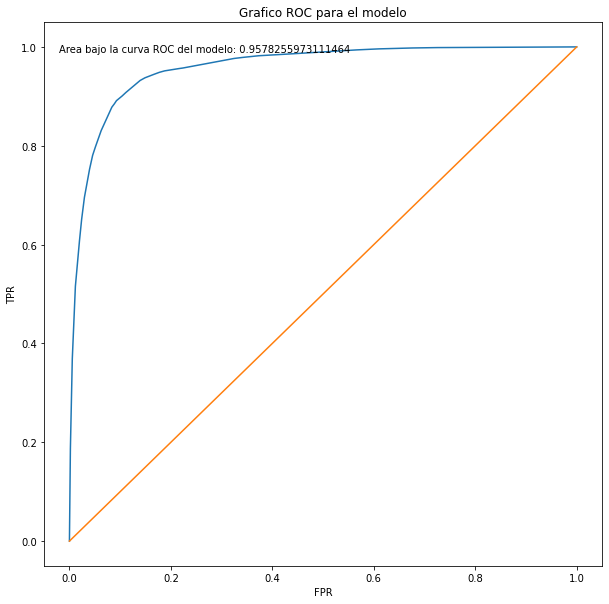

In [ ]:
areaBajoCurvaRoc = roc_auc_score(data3.fallecido, data3Probs)
fpr, tpr, _ = roc_curve(data3.fallecido, data3Probs)
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()